<a href="https://colab.research.google.com/github/machiwao/CCDEPLRL_PROJECT_COM222/blob/main/CCDEPLRL_PROJECT_COM222_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ArtDecode: An Explainable Deep Learning-Based Mobile Application for Multi-Style Artistic Image Classification and Visual Feature Interpretation

In [232]:
import numpy as np
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.regularizers import l2

In [233]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7862235301060581907
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13896777728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10198193202287533670
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 5070 Ti, pci bus id: 0000:01:00.0, compute capability: 12.0"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [234]:
# Clear all previous Keras sessions
tf.keras.backend.clear_session()

## Data Loading

Load images and respective labels

In [235]:
base_dir = r"C:\Users\Blix\Downloads\Data"

In [236]:
styles = os.listdir(base_dir)
print(styles) # Print the list of styles to verify

['Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [318]:
image_height = 224
image_width = 224
batch_size = 48
seed = 42 # For reproducibility

In [319]:
all_image_paths = []
all_labels = []

## Data Split

In [320]:
grouped_styles = [
    'Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Expressionism', 'Fauvism', 
    'Impressionism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art', 'Realism', 'Renaissance', 
    'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e'
]

In [321]:
num_classes = len(grouped_styles)

In [322]:
for i, style_name in enumerate(grouped_styles):
    style_dir = os.path.join(base_dir, style_name)
    if not os.path.exists(style_dir):
        print(f"Warning: Directory for grouped style '{style_name}' not found at {style_dir}")
        continue
    for image_name in os.listdir(style_dir):
        image_path = os.path.join(style_dir, image_name)
        all_image_paths.append(image_path)
        all_labels.append(i)

In [323]:
# Check number of images per style
for style, count in zip(grouped_styles, np.bincount(all_labels)):
    print(f"{style}: {count} images")

Art_Nouveau_Modern: 4334 images
Baroque: 4240 images
Color_Field_Painting: 1615 images
Cubism: 2561 images
Expressionism: 9595 images
Fauvism: 934 images
Impressionism: 20010 images
Minimalism: 1337 images
Naive_Art_Primitivism: 2405 images
Pop_Art: 1483 images
Realism: 11528 images
Renaissance: 6565 images
Rococo: 2089 images
Romanticism: 7019 images
Symbolism: 4528 images
Ukiyo_e: 1167 images


In [324]:
all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

# Perform stratified split
X_train_paths, X_temp_paths, y_train_labels, y_temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.3, random_state=seed, stratify=all_labels
)
X_val_paths, X_test_paths, y_val_labels, y_test_labels = train_test_split(
    X_temp_paths, y_temp_labels, test_size=0.5, random_state=seed, stratify=y_temp_labels
)

## Data Augmentation

In [325]:
def apply_random_saturation(image, factor=0.1):
    return tf.image.random_saturation(image, lower=1-factor, upper=1+factor)

def apply_random_hue(image, delta=0.05):
    return tf.image.random_hue(image, max_delta=delta)

data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(height_factor=0.08, width_factor=0.08, fill_mode='nearest'),
    layers.RandomCrop(height=int(image_height * 0.9), width=int(image_width * 0.9)),
    layers.Resizing(image_height, image_width),
    layers.RandomContrast(0.2),

    layers.Lambda(lambda x: apply_random_saturation(x, factor=0.1), name='manual_random_saturation'),
    layers.Lambda(lambda x: apply_random_hue(x, delta=0.05), name='manual_random_hue'),

    layers.GaussianNoise(0.01),

    tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0))

], name='data_augmentation')

In [326]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # or decode_png if your images are PNG
    img = tf.image.resize(img, [image_height, image_width], method='bicubic')
    img = tf.cast(img, tf.float32) / 255.0 # Normalize to [0, 1]
    label = tf.one_hot(label, num_classes) # One-hot encode labels
    return img, label

In [327]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation_layers(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE) # Apply augmentation
train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [328]:
# Check number of rows per class per dataset
print(f"Number of training samples: {len(X_train_paths)}")
print(f"Number of validation samples: {len(X_val_paths)}")
print(f"Number of test samples: {len(X_test_paths)}")

Number of training samples: 56987
Number of validation samples: 12211
Number of test samples: 12212


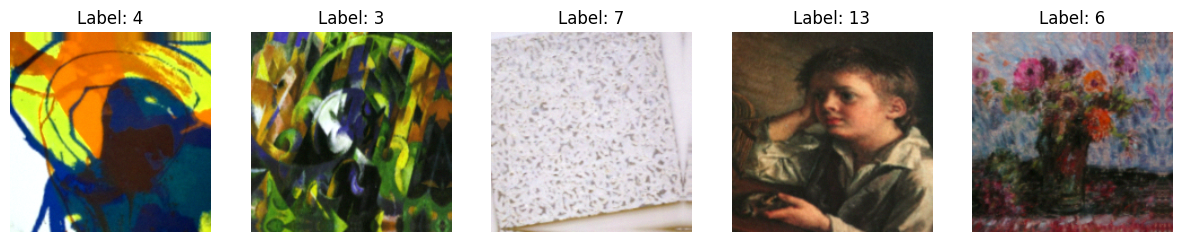

In [329]:
# Display some sample images from the training set
def display_sample_images(dataset, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, (img, label) in enumerate(dataset.take(num_samples)):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img[0].numpy())
        plt.title(f"Label: {np.argmax(label[0].numpy())}")
        plt.axis('off')
    plt.show()
display_sample_images(train_ds)

## Handling Imbalanced Weights

In [330]:
from sklearn.utils import class_weight # For calculating class weights

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights calculated:")
for i, weight in class_weights_dict.items():
    print(f"  Class {grouped_styles[i]} (Index {i}): Weight {weight:.4f}")

Class weights calculated:
  Class Art_Nouveau_Modern (Index 0): Weight 1.1739
  Class Baroque (Index 1): Weight 1.2000
  Class Color_Field_Painting (Index 2): Weight 3.1519
  Class Cubism (Index 3): Weight 1.9864
  Class Expressionism (Index 4): Weight 0.5302
  Class Fauvism (Index 5): Weight 5.4460
  Class Impressionism (Index 6): Weight 0.2543
  Class Minimalism (Index 7): Weight 3.8052
  Class Naive_Art_Primitivism (Index 8): Weight 2.1163
  Class Pop_Art (Index 9): Weight 3.4313
  Class Realism (Index 10): Weight 0.4413
  Class Renaissance (Index 11): Weight 0.7751
  Class Rococo (Index 12): Weight 2.4362
  Class Romanticism (Index 13): Weight 0.7250
  Class Symbolism (Index 14): Weight 1.1236
  Class Ukiyo_e (Index 15): Weight 4.3595


In [331]:
unique_train_labels, train_counts = np.unique(y_train_labels, return_counts=True)
print("Training set class distribution:")
for label, count in zip(unique_train_labels, train_counts):
    print(f"Class {label} ({grouped_styles[label]}): {count} samples")

Training set class distribution:
Class 0 (Art_Nouveau_Modern): 3034 samples
Class 1 (Baroque): 2968 samples
Class 2 (Color_Field_Painting): 1130 samples
Class 3 (Cubism): 1793 samples
Class 4 (Expressionism): 6717 samples
Class 5 (Fauvism): 654 samples
Class 6 (Impressionism): 14007 samples
Class 7 (Minimalism): 936 samples
Class 8 (Naive_Art_Primitivism): 1683 samples
Class 9 (Pop_Art): 1038 samples
Class 10 (Realism): 8070 samples
Class 11 (Renaissance): 4595 samples
Class 12 (Rococo): 1462 samples
Class 13 (Romanticism): 4913 samples
Class 14 (Symbolism): 3170 samples
Class 15 (Ukiyo_e): 817 samples


In [332]:
# Display the class distribution in the validation set
unique_val_labels, val_counts = np.unique(y_val_labels, return_counts=True)
print("Validation set class distribution:")
for label, count in zip(unique_val_labels, val_counts):
    print(f"Class {label} ({grouped_styles[label]}): {count} samples")

Validation set class distribution:
Class 0 (Art_Nouveau_Modern): 650 samples
Class 1 (Baroque): 636 samples
Class 2 (Color_Field_Painting): 242 samples
Class 3 (Cubism): 384 samples
Class 4 (Expressionism): 1439 samples
Class 5 (Fauvism): 140 samples
Class 6 (Impressionism): 3001 samples
Class 7 (Minimalism): 201 samples
Class 8 (Naive_Art_Primitivism): 361 samples
Class 9 (Pop_Art): 223 samples
Class 10 (Realism): 1729 samples
Class 11 (Renaissance): 985 samples
Class 12 (Rococo): 313 samples
Class 13 (Romanticism): 1053 samples
Class 14 (Symbolism): 679 samples
Class 15 (Ukiyo_e): 175 samples


In [333]:
# Display the class distribution in the test set
unique_test_labels, test_counts = np.unique(y_test_labels, return_counts=True)
print("Test set class distribution:")
for label, count in zip(unique_test_labels, test_counts):
    print(f"Class {label} ({grouped_styles[label]}): {count} samples")
    

Test set class distribution:
Class 0 (Art_Nouveau_Modern): 650 samples
Class 1 (Baroque): 636 samples
Class 2 (Color_Field_Painting): 243 samples
Class 3 (Cubism): 384 samples
Class 4 (Expressionism): 1439 samples
Class 5 (Fauvism): 140 samples
Class 6 (Impressionism): 3002 samples
Class 7 (Minimalism): 200 samples
Class 8 (Naive_Art_Primitivism): 361 samples
Class 9 (Pop_Art): 222 samples
Class 10 (Realism): 1729 samples
Class 11 (Renaissance): 985 samples
Class 12 (Rococo): 314 samples
Class 13 (Romanticism): 1053 samples
Class 14 (Symbolism): 679 samples
Class 15 (Ukiyo_e): 175 samples


## Model Training

In [334]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


## Resnet-18

In [335]:
def conv_block(x, filters, kernel_size=3, strides=1, use_projection=False, weight_decay=1e-3, name=None):
    l2 = regularizers.l2(weight_decay)

    shortcut = x
    if use_projection:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same',
                                 kernel_regularizer=l2, name=f'{name}_proj')(x)
        shortcut = layers.BatchNormalization(name=f'{name}_proj_bn')(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same',
                      kernel_regularizer=l2, name=f'{name}_conv1')(x)
    x = layers.BatchNormalization(name=f'{name}_bn1')(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same',
                      kernel_regularizer=l2, name=f'{name}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name}_bn2')(x)

    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

def build_resnet18_gradcam(input_shape=(224, 224, 3), num_classes=len(grouped_styles), dropout_rate=0.5, weight_decay=1e-3):
    inputs = tf.keras.Input(shape=input_shape)
    l2 = regularizers.l2(weight_decay)

    # Initial Conv + MaxPool
    x = layers.Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=l2, name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Conv2_x
    x = conv_block(x, 64, strides=1, use_projection=False, weight_decay=weight_decay, name='conv2_1')
    x = conv_block(x, 64, strides=1, use_projection=False, weight_decay=weight_decay, name='conv2_2')

    # Conv3_x
    x = conv_block(x, 128, strides=2, use_projection=True, weight_decay=weight_decay, name='conv3_1')
    x = conv_block(x, 128, strides=1, use_projection=False, weight_decay=weight_decay, name='conv3_2')

    # Conv4_x
    x = conv_block(x, 256, strides=2, use_projection=True, weight_decay=weight_decay, name='conv4_1')
    x = conv_block(x, 256, strides=1, use_projection=False, weight_decay=weight_decay, name='conv4_2')

    # Conv5_x
    x = conv_block(x, 512, strides=2, use_projection=True, weight_decay=weight_decay, name='conv5_1')
    x = conv_block(x, 512, strides=1, use_projection=False, weight_decay=weight_decay, name='conv5_2')
    last_conv_output = x  # For Grad-CAM

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2, name='fc')(x)

    model = models.Model(inputs=inputs, outputs=x, name='ResNet18_GradCAM')
    return model

In [336]:
# Define the model
resnet18_gradcam = build_resnet18_gradcam(input_shape=(image_height, image_width, 3), num_classes=num_classes, dropout_rate=0.5, weight_decay=1e-4)
resnet18_gradcam.summary()

Model: "ResNet18_GradCAM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 112, 112, 64  256         ['conv1[0][0]']                  
                                )                                                  

In [337]:
# Initialize starting learning rate
base_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

resnet18_gradcam.compile(
    optimizer=base_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=['accuracy']
)

In [338]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 15,
    restore_best_weights=True,
    verbose=1,
    min_delta=1e-5,
)

In [339]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # Reduce LR by half
    patience=10,        # Wait 3 epochs before reducing
    min_lr=1e-7,       # Don't go below this
    min_delta=1e-5,
    verbose=1
)

In [340]:
# Fit the model
resnet18_gradcam = resnet18_gradcam.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[early_stop, reduce_lr],
    class_weight = class_weights_dict
)

Epoch 1/1000
1188/1188 [==============================] - 258s 212ms/step - loss: 3.1570 - accuracy: 0.1398 - val_loss: 3.2172 - val_accuracy: 0.1219 - lr: 1.0000e-04
Epoch 2/1000
 678/1188 [================>.............] - ETA: 1:42 - loss: 2.7949 - accuracy: 0.2004

KeyboardInterrupt: 

### Model Evaluation

In [298]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 12))
  ax1.plot(history.history['accuracy'])
  ax1.plot(history.history['val_accuracy'])
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'validation'], loc='upper left')
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')

TypeError: 'History' object is not subscriptable

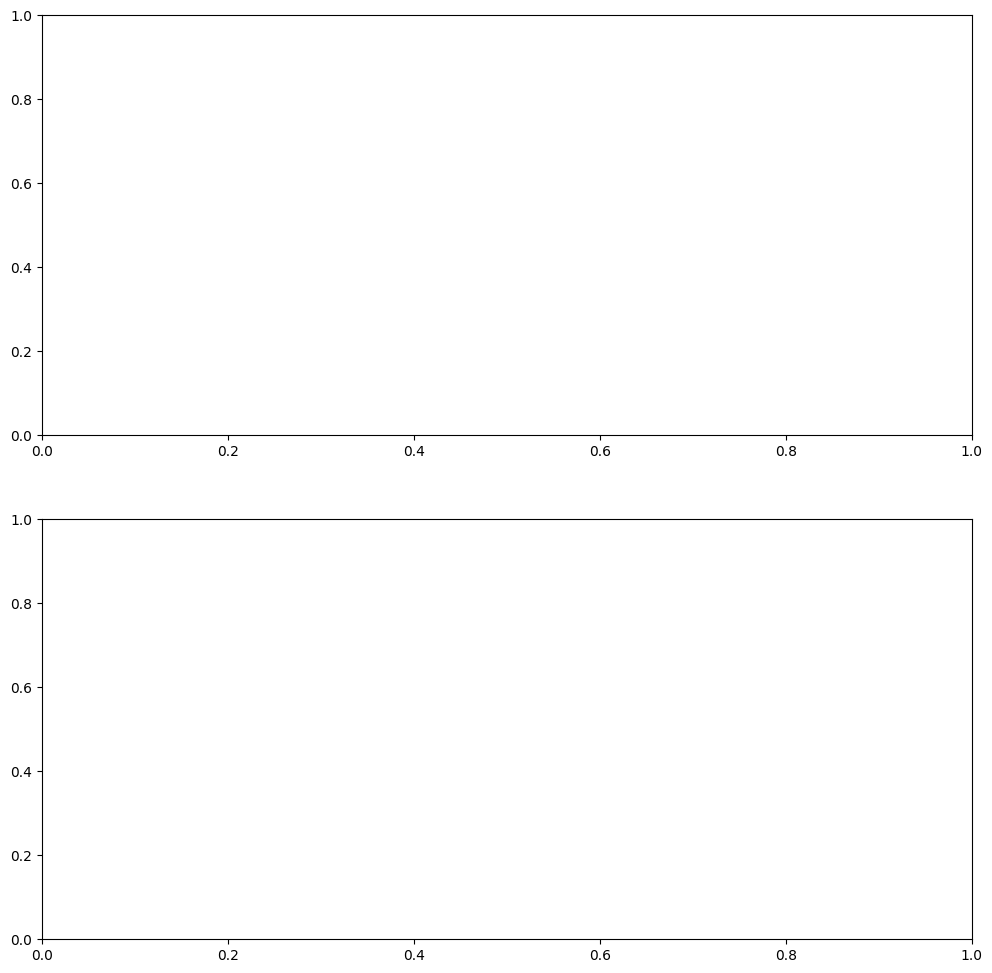

In [341]:
# Plot Loss Graphs
plot_history(resnet18_gradcam)

In [301]:
# Evaluate the model on the test set
test_loss, test_accuracy = resnet18_gradcam.evaluate(test_ds)

191/191 [==============================] - 14s 73ms/step - loss: 2.2769 - accuracy: 0.4026


In [302]:
# Print the test accuracy and loss
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 2.2769
Test Accuracy: 0.4026


In [305]:
# Save the model as tflite
converter = tf.lite.TFLiteConverter.from_keras_model(resnet18_gradcam)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('resnet16_gradcam.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Save the model in HDF5 format
resnet18_gradcam.save('resnet16_gradcam.h5')

# Save the model in SavedModel format
resnet18_gradcam.save('resnet16_gradcam_saved_model', save_format='tf')

# Save the keras model
resnet18_gradcam.save('resnet16_gradcam.keras')


INFO:tensorflow:Assets written to: C:\Users\Blix\AppData\Local\Temp\tmpbqoiqgf8\assets


INFO:tensorflow:Assets written to: C:\Users\Blix\AppData\Local\Temp\tmpbqoiqgf8\assets


INFO:tensorflow:Assets written to: resnet16_gradcam_saved_model\assets


INFO:tensorflow:Assets written to: resnet16_gradcam_saved_model\assets


In [308]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = resnet18_gradcam.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Correct way to get true labels for comparison
y_true_labels_one_hot = []
for _, y_batch in test_ds:
    y_true_labels_one_hot.append(y_batch.numpy())

# Concatenate all one-hot batches and then convert them to integer labels
y_true_classes = np.argmax(np.concatenate(y_true_labels_one_hot, axis=0), axis=1)


print("Classification Report:")
# Ensure target_names matches the order of your class indices
print(classification_report(y_true_classes, y_pred_classes, target_names=grouped_styles))

191/191 [==============================] - 14s 75ms/step
Classification Report:
                       precision    recall  f1-score   support

   Art_Nouveau_Modern       0.29      0.49      0.36       650
              Baroque       0.47      0.32      0.38       636
 Color_Field_Painting       0.45      0.68      0.54       243
               Cubism       0.60      0.21      0.31       384
        Expressionism       0.34      0.30      0.32      1439
              Fauvism       0.15      0.15      0.15       140
        Impressionism       0.77      0.40      0.52      3002
           Minimalism       0.43      0.62      0.51       200
Naive_Art_Primitivism       0.16      0.30      0.21       361
              Pop_Art       0.17      0.64      0.27       222
              Realism       0.50      0.28      0.36      1729
          Renaissance       0.47      0.63      0.54       985
               Rococo       0.46      0.39      0.42       314
          Romanticism       0.32     

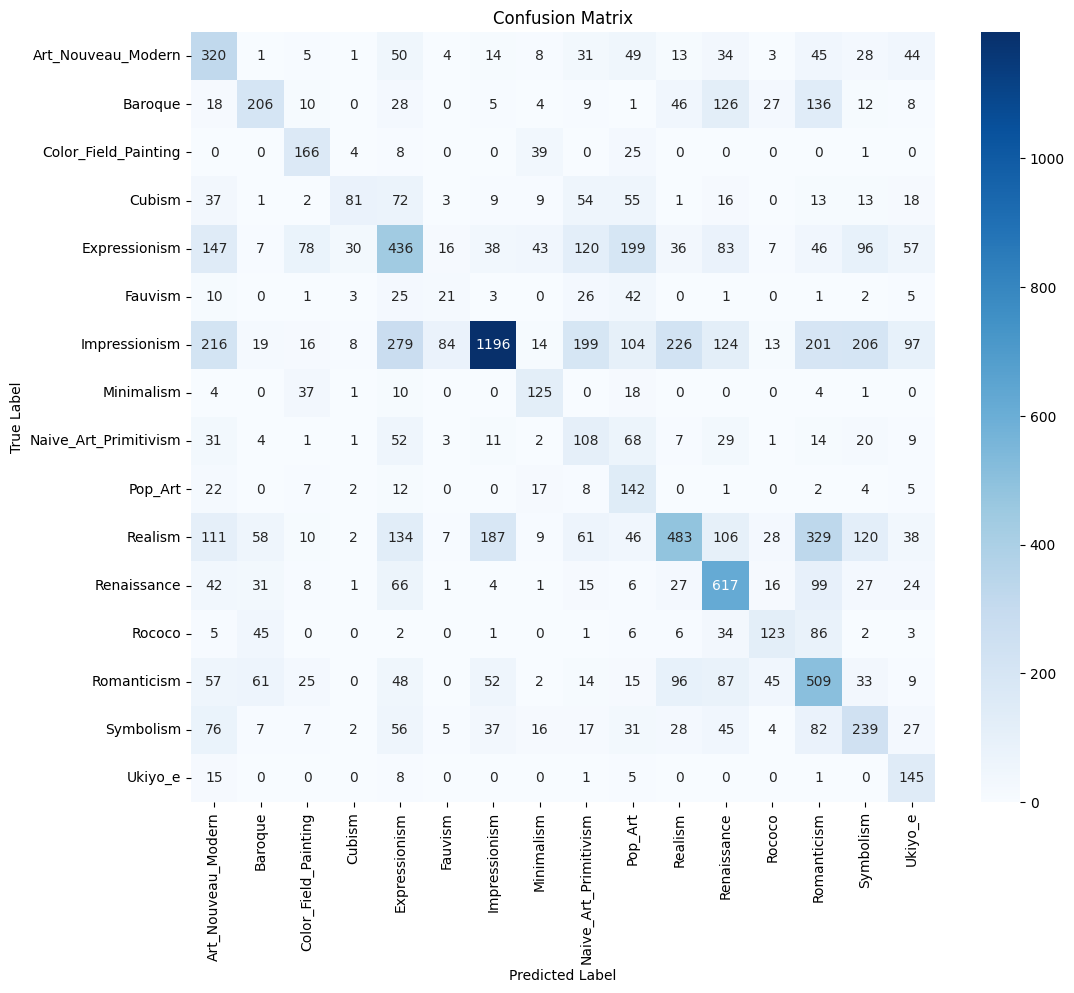

In [311]:
# Generate Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=grouped_styles, yticklabels=grouped_styles)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [312]:
# Show GRAD-CAM for top three images for each class
def get_gradcam_heatmap(model, img_array, last_conv_layer_name='conv5_2', pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [313]:
def display_gradcam(img_path, model, last_conv_layer_name='conv5_2'):
    img = image.load_img(img_path, target_size=(image_height, image_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.cast(img_array, tf.float32) / 255.0  # Normalize to [0, 1]

    heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.show()

In [317]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For colormaps
from tensorflow.keras import models, layers, regularizers # Make sure layers and models are imported


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4, title="", cmap_name='jet'):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use a colormap to colorize the heatmap
    cmap = cm.get_cmap(cmap_name)
    colors = cmap(np.arange(256))[:, :3] # Get RGB values from colormap
    heatmap_colored = colors[heatmap]

    heatmap_img = tf.keras.preprocessing.image.array_to_img(heatmap_colored)
    heatmap_img = heatmap_img.resize((img.shape[1], img.shape[0]))

    if img.dtype != np.uint8:
        img_display = np.uint8(255 * img)
    else:
        img_display = img # Already uint8

    img_pil = tf.keras.preprocessing.image.array_to_img(img_display)

    img_array_for_blend = np.array(img_pil)
    heatmap_img_array_for_blend = np.array(heatmap_img)

    superimposed_img = img_array_for_blend * (1 - alpha) + heatmap_img_array_for_blend * alpha
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(title)


LAST_CONV_LAYER_NAME = 'conv5_2_bn2'

top_correct_predictions_per_class = {}

print("Collecting top confidence correct predictions for each class...")

all_test_images = []
all_test_labels_one_hot = []
for batch_images, batch_labels in test_ds:
    all_test_images.append(batch_images.numpy())
    all_test_labels_one_hot.append(batch_labels.numpy())

all_test_images = np.concatenate(all_test_images, axis=0)
all_test_labels = np.argmax(np.concatenate(all_test_labels_one_hot, axis=0), axis=1)

all_test_predictions = resnet18_gradcam.predict(all_test_images)
all_test_pred_classes = np.argmax(all_test_predictions, axis=1)

for i in range(len(all_test_images)):
    true_label_idx = all_test_labels[i]
    predicted_label_idx = all_test_pred_classes[i]
    confidence = all_test_predictions[i, predicted_label_idx] # Confidence of the predicted class

    # Check if prediction is correct AND if it's the highest confidence for this class yet
    if true_label_idx == predicted_label_idx: # Correct prediction
        if true_label_idx not in top_correct_predictions_per_class or \
           confidence > top_correct_predictions_per_class[true_label_idx][1]:
            top_correct_predictions_per_class[true_label_idx] = (
                all_test_images[i], confidence, true_label_idx # Store image, confidence, true_label
            )

print("Found top correct predictions for the following classes:",
      [grouped_styles[k] for k in top_correct_predictions_per_class.keys()])

# --- Visualize Grad-CAM for each collected image ---
plt.figure(figsize=(20, 4 * ((num_classes + 3) // 4))) # Adjust figure size dynamically
plot_count = 0

for class_idx in sorted(top_correct_predictions_per_class.keys()):
    img_array, confidence, true_label_idx = top_correct_predictions_per_class[class_idx]
    
    # Add batch dimension for make_gradcam_heatmap function
    img_array_batch = np.expand_dims(img_array, axis=0)

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array_batch, resnet18_gradcam, LAST_CONV_LAYER_NAME, pred_index=true_label_idx)

    # Plotting
    plot_count += 1
    plt.subplot((num_classes + 3) // 4, 4, plot_count) # 4 columns per row
    display_gradcam(img_array, heatmap, alpha=0.4, 
                    title=f"Style: {grouped_styles[true_label_idx]}\nConf: {confidence:.2f}")

plt.tight_layout()
plt.show()


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.